### Correlation between population response to the Monkey(natural)-Monkey(unatural) and Face(natural)+Body(natural)

In [16]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')
# import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [68]:
result_dir = Path('../results/')
pd_diff_all = []

trained = [False, True]
for itr in trained:
    resp_name = f'alexnet_trained_{itr}_inputsize_500.pkl'
    resp_dir = result_dir / 'data' / 'net_resp' / resp_name
    with open(resp_dir, 'rb') as f: # loding network response 
        out = pickle.load(f)
    df = pd.read_csv('../data/df_stim.csv') # laoding metadata

    layers = ["Layer5", "Layer6", "Layer7"]
    # pd_diff_all = []
    for ilayer in layers:
        # extracting and reformating the response
        resp5 = out[ilayer]
        resp5_sub = resp5 - resp5[-1]
        resp5_out = resp5_sub[:-1].detach().numpy()
        resp5_out = resp5_out.reshape(120, -1) # excluding the background response
        # taking out the inactive units 
        zero_idx = ~np.all(resp5_out == 0, axis=0)
        resp5_out = resp5_out[:, zero_idx]

        # collecting the response for different conditions    
        df_MBody_N = df[(df['stim'] == 'MBody') & (df['type'] == 'R')]
        df_Mon_U = df[(df['stim'] == 'Mon') & (df['type'] == 'Irr')]
        df_Mon_N= df[(df['stim'] == 'Mon') & (df['type'] == 'R')]
        df_MFace_N = df[(df['stim'] == 'MFace') & (df['type'] == 'R')]
        rsp_MN = resp5_out[df_Mon_N.index.values]
        rsp_MU = resp5_out[df_Mon_U.index.values]
        rsp_F = resp5_out[df_MFace_N.index.values]
        rsp_B = resp5_out[df_MBody_N.index.values]
        rsp_sum = rsp_F + rsp_B

        # mean across instances of the conditions 
        mean_rsp_MN = rsp_MN.mean(axis=0)
        mean_rsp_MU = rsp_MU.mean(axis=0)
        mean_rsp_sum = rsp_sum.mean(axis=0)

        # calculating contrasts
        diff_M = np.divide(mean_rsp_MN-mean_rsp_MU, abs(mean_rsp_MN) + abs(mean_rsp_MU))
        diff_sum = np.divide(mean_rsp_MN -mean_rsp_sum ,  abs(mean_rsp_MN) + abs(mean_rsp_sum))

        # putting them in a dataframe 
        pd_diff = pd.DataFrame({'contrast(MN,MU)': diff_M, 'contrast(MN,Sum)': diff_sum})
        pd_diff['layer']= ilayer
        pd_diff['trained'] = itr
        pd_diff_all.append(pd_diff) #collecting dataframes for each layer
    
    # pd_diff_all = pd.concat(pd_diff_all, axis=0)
    # pd_diff_all['trained'] = itr

pd_diff_all = pd.concat(pd_diff_all, axis=0)
# pd_diff_all

,"contrast(MN,MU)","contrast(MN,Sum)",layer,trained
0,0.138875,0.808705,Layer5,False
1,-0.808403,-0.542997,Layer5,False
2,0.211248,0.032537,Layer5,False
3,0.357118,0.012000,Layer5,False
4,0.106068,0.008026,Layer5,False
...,...,...,...,...
2208,0.214650,0.537750,Layer7,True
2209,0.593180,0.134154,Layer7,True
2210,-0.983170,-0.995048,Layer7,True
2211,NaN,-1.000000,Layer7,True


In [69]:
def annotate_nUnits(g, data, **kws):
    N = np.round(data.groupby(['trained', 'layer']).corr(method='spearman')['contrast(MN,MU)'].values[[1, 3, 5, 7, 9, 11]], 2)
    id = 0
    for ax in g.axes.flat:
        ax.text(0.05, 0.85,f'Spearman\'s rho ={N[id]}', \
             fontsize=9, transform=ax.transAxes, bbox = dict(facecolor='white', alpha=0.7, edgecolor='gray'))
        id +=1

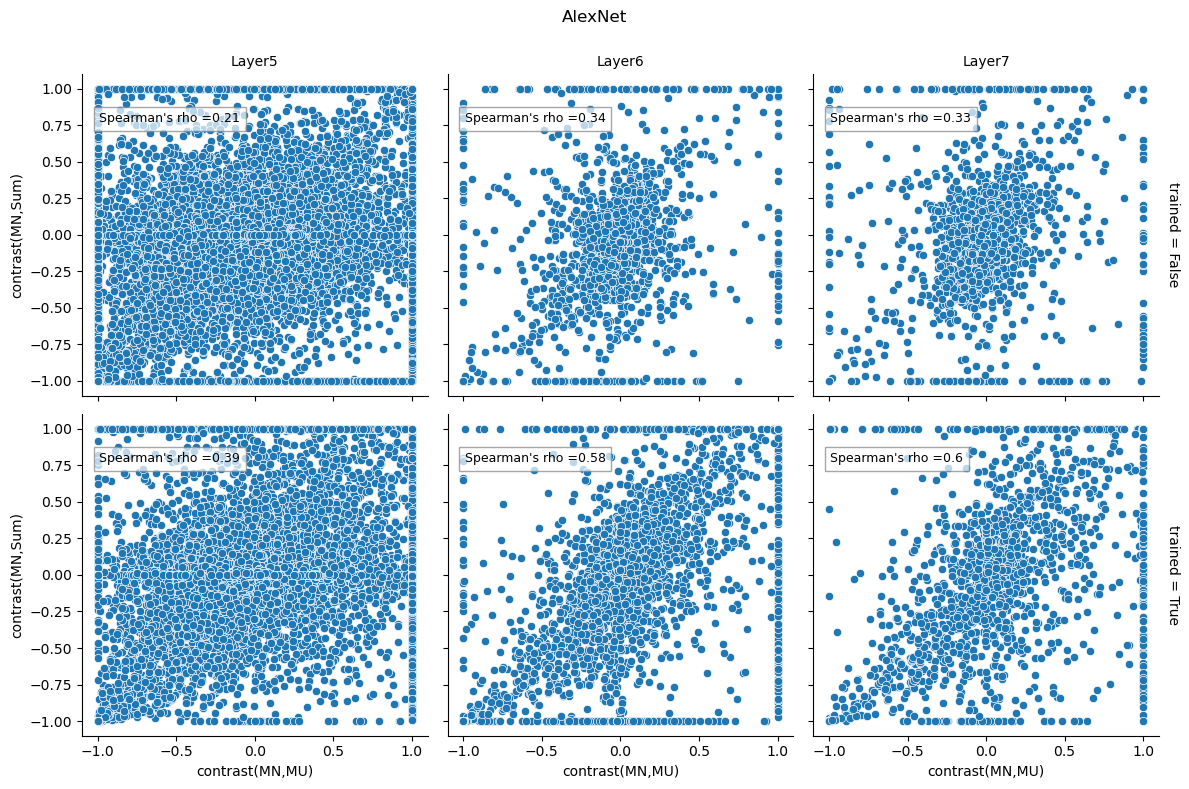

In [71]:
import seaborn as sns
g = sns.FacetGrid(data=pd_diff_all, col='layer', row='trained', height=4, margin_titles=True)
g.map_dataframe(sns.scatterplot,x='contrast(MN,MU)', y='contrast(MN,Sum)' )
annotate_nUnits(g, pd_diff_all)
g.set_titles(col_template='{col_name}')
g.fig.suptitle('AlexNet')
g.fig.subplots_adjust(top=0.90)
g.fig.savefig('../results/plots/corr_contrasts.png', format='png', bbox_inches='tight', dpi=300)

In [54]:
pd_diff_all.groupby(['trained', 'layer']).corr(method='spearman')['MN-MU'].values[[1, 3, 5, 7, 9, 11]]

array([0.20505813, 0.3442119 , 0.32804314, 0.38556354, 0.58402113,
       0.59829433])